In [3]:
import numpy as np
import pandas as pd
import torch
import transformers

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression

from nltk.tokenize.casual import TweetTokenizer

import matplotlib.pyplot as plt

In [4]:
ann_1 = pd.read_csv('./annotations_1.csv')
ann_1.head()

,Tweet,Annotation,Guideline
0,RT @mindales: BTS Stranger Things AU poster co...,Not Humorous,"""Trivia, facts, news headlines"""
1,RT @DEvansThe2nd: Kuz is that one freshman who...,Humorous,"""A tweet containing a 😂 or similar emoji, acro..."
2,RT @ExAmish101: I was Amish and was sexually a...,Not Humorous,"""Statements that make absolutely no attempt at..."
3,My son look like he sell stogies 3 dollars a pack,Humorous,"Unsure - ""Tweets that are sarcastic or making ..."
4,I've come to the conclusion that I might be a ...,Unsure,Don't understand


In [5]:
ann_1.groupby('Annotation').count()

,Tweet,Guideline
Annotation,,
Humorous,44,44
Not Humorous,166,166
Unsure,40,12


In [5]:
ann_1['Annotation'] = ann_1['Annotation'].astype('category')

In [6]:
ann_1.dtypes

Tweet           object
Annotation    category
Guideline       object
dtype: object

In [7]:
ann_2 = pd.read_csv('./annotations_2.csv')
ann_2['Annotation'] = ann_2['Annotation'].astype('category')
ann_2.dtypes

Tweet           object
Annotation    category
Guideline       object
dtype: object

In [8]:
anns = ann_1.copy()

In [9]:
anns.rename(columns={'Annotation': 'ann_1'}, inplace=True)

In [14]:
anns['ann_2'] = ann_2['Annotation']
anns.drop('Guideline', axis=1, inplace=True)
anns.head()

,Tweet,ann_1,ann_2
0,RT @mindales: BTS Stranger Things AU poster co...,Not Humorous,Not Humorous
1,RT @DEvansThe2nd: Kuz is that one freshman who...,Humorous,Humorous
2,RT @ExAmish101: I was Amish and was sexually a...,Not Humorous,Not Humorous
3,My son look like he sell stogies 3 dollars a pack,Humorous,Humorous
4,I've come to the conclusion that I might be a ...,Unsure,Not Humorous


In [15]:
dataset = anns.copy()
# 0 -> Humor, 1 -> Not Humor 2 -> Unsure
dataset.ann_1 = dataset.ann_1.cat.codes
dataset.ann_2 = dataset.ann_2.cat.codes
dataset.head()

,Tweet,ann_1,ann_2
0,RT @mindales: BTS Stranger Things AU poster co...,1,1
1,RT @DEvansThe2nd: Kuz is that one freshman who...,0,0
2,RT @ExAmish101: I was Amish and was sexually a...,1,1
3,My son look like he sell stogies 3 dollars a pack,0,0
4,I've come to the conclusion that I might be a ...,2,1


In [41]:
dataset.query('ann_1 == 0 and ann_2 == 0').count()

Tweet    33
ann_1    33
ann_2    33
dtype: int64

In [24]:
agreement = dataset.query('(ann_1 == 0 and ann_2 == 0) or (ann_1 == 1 and ann_2 == 1)')

In [25]:
agreement.head()

,Tweet,ann_1,ann_2
0,RT @mindales: BTS Stranger Things AU poster co...,1,1
1,RT @DEvansThe2nd: Kuz is that one freshman who...,0,0
2,RT @ExAmish101: I was Amish and was sexually a...,1,1
3,My son look like he sell stogies 3 dollars a pack,0,0
5,careful where you plant them seeds before you ...,1,1


In [34]:
dataset['final_anns'] = [False]*250

In [35]:
dataset['final_anns'][agreement.index] = True

/Users/sanchitnevgi/anaconda3/envs/commonsense/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
dataset.to_csv('agg_annotations.csv')

In [50]:
final = pd.read_csv('final_dataset.csv')
final.drop(['ann_1', 'ann_2', 'final_anns'], axis=1, inplace=True)
final.to_csv('train.csv')
final.head()

,Tweet,ann
0,@mindales: BTS Stranger Things AU poster conce...,1
1,@DEvansThe2nd: Kuz is that one freshman who's ...,0
2,@ExAmish101: I was Amish and was sexually abus...,1
3,My son look like he sell stogies 3 dollars a pack,0
4,I've come to the conclusion that I might be a ...,1


In [41]:
final.groupby('ann').count()

,Tweet
ann,
0,62
1,188


In [46]:
text = '@mindales: BTS Stranger Things AU poster concept @BTS_twt https://t.co/LytZhKkAbr'

In [48]:
tokenizer = TweetTokenizer()

In [60]:
tokenizer.tokenize(train_raw.iloc[7,0])

['<user>',
 ':',
 'sir',
 'john',
 'lion',
 'king',
 'makeup',
 'collection',
 '🦁',
 'review',
 ',',
 'lip',
 'swatches',
 '&',
 'tutorial',
 '<url>',
 '<url>']

In [56]:
tokenized_text = tokenizer.tokenize(text)
bert_tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
# Training data with raw unprocessed tweets
# train_raw = pd.read_csv('train_raw.csv', index_col='id')
train_raw = pd.read_csv('processed_tweets.csv')

In [7]:
train_raw.head()

,tweet,label
0,<user>: bts stranger things au poster concept ...,1
1,<user>: kuz is that one freshman who's kicking...,0
2,<user>: i was amish and was sexually abused fo...,1
3,my son look like he sell stogies <number> doll...,0
4,i've come to the conclusion that i might be a ...,1


In [21]:
vectorizer = CountVectorizer()
# vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_raw.tweet).toarray()
y = train_raw.label
X.shape

(250, 1362)

In [9]:
def train(X, y):
    model = LogisticRegression(random_state=42)
    kf = KFold(n_splits=5)
    accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, y_train = X[train_index], y[train_index]
        model.fit(X_train, y_train)

        X_test, y_test = X[test_index], y[test_index]
        predictions = model.predict(X_test)

        accuracies.append((predictions == y_test).mean())
    
    print(accuracies)
    print('k-fold mean accuracy', np.array(accuracies).mean())
    
    return model

In [22]:
model = train(X, y)

def evaluate():
    preds = model.predict(X)
    acc = (preds == y).mean()

    print("Accuracy: ", acc)
    
    return acc

[0.74, 0.8, 0.74, 0.72, 0.74]
k-fold mean accuracy 0.748


In [23]:
y_pred = model.predict(X)
precision_recall_fscore_support(train_raw.label, y_pred, average=None)

(array([0.97826087, 0.91666667]),
 array([0.72580645, 0.99468085]),
 array([0.83333333, 0.95408163]),
 array([ 62, 188]))

Text(0.5, 1.0, 'Precision recall curve on Bag-of-words model with tf-idf')

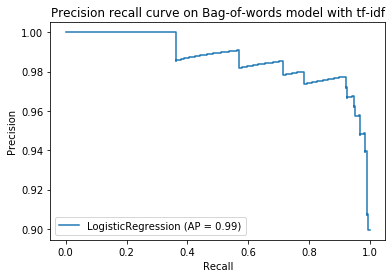

In [151]:
disp = plot_precision_recall_curve(model, X, y)
disp.ax_.set_title('Precision recall curve on Bag-of-words model with tf-idf')

In [119]:
sanity = vectorizer.transform(['In other news, the trump rally continues'])
model.predict(sanity)

array([1])

In [37]:
import re
lines = []
with open('glove.txt', 'r') as reader:
    for line in reader:
        no_arabic = re.match("[\u0621-\u064A0-9]+", line) is None
        if no_arabic:
            lines.append(line)

In [10]:
word_to_idx = {}
em_matrix = []
idx = 0
with open('glove.txt', 'r') as reader:
    for line in reader:
        word, *embedding = line.split(' ')
        word_to_idx[word] = idx
        idx += 1
        em_matrix.append(embedding)
em = np.array(em_matrix)

In [11]:
print(em.shape)

(982, 25)


In [12]:
tokenizer = TweetTokenizer()
X_embedding = []

for tweet in train_raw.tweet:
    tweet_embedding = np.zeros(25)
    
    tokens = tokenizer.tokenize(tweet)
    for token in tokens:
        try: 
            tweet_embedding += em[word_to_idx[token]]
        except:
            new_embedding = np.random.rand(25) * 2 - 1
        
            word_to_idx[token] = idx
            idx += 1

            tweet_embedding += new_embedding
            em = np.vstack((em, new_embedding))
    
    tweet_embedding /= len(tokens) 
    
    X_embedding.append(tweet_embedding)

X_embedding = np.vstack(X_embedding)
X_embedding.shape

(250, 25)

In [13]:
model = train(X_embedding, train_raw.label)

[0.7, 0.78, 0.74, 0.76, 0.74]
k-fold mean accuracy 0.744


In [14]:
from sklearn.metrics import precision_recall_fscore_support

In [16]:
y_pred = model.predict(X_embedding)
precision_recall_fscore_support(train_raw.label, y_pred, average=None)

/Users/sanchitnevgi/anaconda3/envs/commonsense/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.   , 0.752]),
 array([0., 1.]),
 array([0.        , 0.85844749]),
 array([ 62, 188]))

Text(0.5, 1.0, 'Precision recall curve using Twitter GloVe embeddings (1000 vocab, 25-d)')

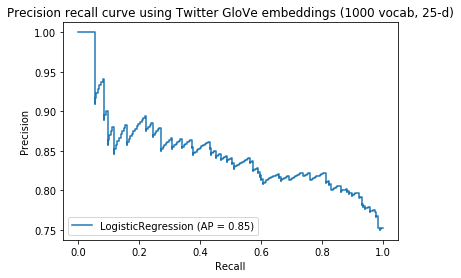

In [153]:
disp = plot_precision_recall_curve(model, X_embedding, train_raw.label)
disp.ax_.set_title('Precision recall curve using Twitter GloVe embeddings (1000 vocab, 25-d)')

In [93]:
bert_tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [94]:
tweets_tensor = torch.load('tweets.pt')

In [96]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler

In [101]:
tweets = DataLoader(tweets_tensor, batch_size=8)

**BertForSequenceClassification**

Epochs: 1, Acc: 0.752


Epochs: 3, Acc: 0.928

In [25]:
from collections import Counter
from functools import reduce

def get_tweets(label):
    humor = train_raw[train_raw.label == label].tweet
    tokenizer = TweetTokenizer()
    words = humor.apply(lambda tweet: tokenizer.tokenize(tweet))
    words = reduce(lambda x, y: x + y, words)
    return words

# BERT training script

In [ ]:
import argparse
from tqdm import tqdm, trange

import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import (
    AdamW,
    BertTokenizer,
    BertForSequenceClassification
)

def train(args, train_dataset, model, tokenizer):
    args.train_batch_size = 8
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=args.train_batch_size)

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)

    tr_loss = 0

    model.zero_grad()
    train_iterator = trange(int(args.num_train_epochs), desc="Epoch")

    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration")
        
        for step, batch in enumerate(epoch_iterator):
            model.train()

            inputs = {
                "input_ids": batch[0].view(-1, 250),
                "attention_mask": batch[1].view(-1, 250),
                "labels": batch[2],
            }

            outputs = model(**inputs)
            loss = outputs[0]

            loss.backward()

            tr_loss += loss.item()

            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

            optimizer.step()

            model.zero_grad()

def evaluate(args, model, tokenizer):
    eval_dataset = torch.load('./tweets.pt')
    eval_dataloader = DataLoader(eval_dataset, batch_size=8)

    preds = None
    out_label_ids = None

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0].view(-1, 250),
                "attention_mask": batch[1].view(-1, 250),
                "labels": batch[2],
            }

            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]
        
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)
        
    preds = np.argmax(preds, axis=1)
    acc = (preds == out_label_ids).mean()
    print("Acc: " + str(acc))


def main():
    parser = argparse.ArgumentParser()

    parser.add_argument("--per_gpu_train_batch_size", default=8, type=int, help="Batch size per GPU/CPU for training.")

    parser.add_argument("--learning_rate", default=5e-5, type=float, help="The initial learning rate for Adam.")
    parser.add_argument("--weight_decay", default=0.0, type=float, help="Weight decay")
    parser.add_argument("--adam_epsilon", default=1e-8, type=float, help="Epsilon for Adam optimizer.")
    parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")

    parser.add_argument(
        "--num_train_epochs", default=3.0, type=float, help="Total number of training epochs to perform."
    )

    args = parser.parse_args()

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    train(args, torch.load('./tweets.pt'), model, tokenizer)
    
    model.save_pretrained('./trained-model')

    evaluate(args, model, tokenizer)

if __name__ == "__main__":
    main()